In [1]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from dataset import TinyShakes

from cosmosis.model import GPT
from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
# explore the ds

ds_param = {'transforms': {'X1': [AsTensor()],
                           'X2': [AsTensor()]},
            'block_size': 6,
            'n': 1}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['X1'].shape, ts[0]['X1'].dtype)
print(ts[0]['X2'].shape, ts[0]['X2'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['X1'].tolist()))

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  1
data.nbytes:  676050
CDataset created...
{'X1': tensor([ 5962, 22307,    25,   198,  8421,   356]), 'X2': tensor([22307,    25,   198,  8421,   356,  5120])}
torch.Size([6]) torch.int64
torch.Size([6]) torch.int64
decoded tokens:  First Citizen:
Before we


In [3]:
# example using prompt for inference

ds_param = {'transforms': {'X1': [AsTensor()],
                           'X2': [AsTensor()]},
            'block_size': 20,
            'prompt': 'All the worlds a stage and all the men and women merely'}

ts_infer = TinyShakes(**ds_param)
print(ts_infer[0])
print(ts_infer[0]['X1'].shape)
print(ts_infer[0]['X2'].shape)
print('decoded tokens: ', ts.encoding.decode(ts_infer[0]['X1'].tolist()))

len(self.ds_idx):  1
data.nbytes:  24
CDataset created...
{'X1': tensor([ 3237,   262, 11621,   257,  3800,   290,   477,   262,  1450,   290,
         1466,  6974]), 'X2': tensor([  262, 11621,   257,  3800,   290,   477,   262,  1450,   290,  1466,
         6974])}
torch.Size([12])
torch.Size([11])
decoded tokens:  All the worlds a stage and all the men and women merely


In [4]:
# load single data example into model and examine output

d_vocab = 50304 # tokenizer's vocab size
model_param = {'device': 'cpu',
               'd_model': 32, # matches embedding dimension
               'd_vocab': d_vocab, 
               'n_head': 2, 
               'num_layers': 2,
               'linear_head': True,
               'probs': True, # softmax
               'tokens': True, # multinomial
               'transpose': False, 
               'embed_param': {'X1': (d_vocab, 32, None, True), 
                               'X2': (d_vocab, 32, None, True)}} 

gpt = GPT(model_param)

data = ts_infer[0]
out = gpt(data)
print('output: ', out, out.shape, out.dtype)

prompt_tokens = data['X2']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['X1']
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_tokens = out.squeeze()
print('generated_tokens: ', generated_tokens, generated_tokens.shape, generated_tokens.dtype)
print('decoded tokens: ', ts.encoding.decode(generated_tokens.tolist()))

CModel loaded...
output:  tensor([[29900],
        [24612],
        [41447],
        [45394],
        [21154],
        [28785],
        [48282],
        [ 8864],
        [41917],
        [47361],
        [ 4032],
        [44962]]) torch.Size([12, 1]) torch.int64
prompt_tokens:  tensor([  262, 11621,   257,  3800,   290,   477,   262,  1450,   290,  1466,
         6974]) torch.Size([11]) torch.int64
target_tokens:  tensor([ 3237,   262, 11621,   257,  3800,   290,   477,   262,  1450,   290,
         1466,  6974]) torch.Size([12]) torch.int64
generated_tokens:  tensor([29900, 24612, 41447, 45394, 21154, 28785, 48282,  8864, 41917, 47361,
         4032, 44962]) torch.Size([12]) torch.int64
decoded tokens:   undergone representations depressmarriage counters Cory Implement................................ geological Referred,'GOP


In [5]:
# load single data example into model and examine output and pass into loss func

d_vocab = 50304 # tokenizer's vocab size
model_param = {'device': 'cpu',
               'd_model': 32, # matches embedding dimension
               'd_vocab': d_vocab, 
               'n_head': 2, 
               'num_layers': 2,
               'linear_head': True,
               'probs': False, # softmax
               'tokens': False, # multinomial
               'transpose': False, 
               'embed_param': {'X1': (d_vocab, 32, None, True), 
                               'X2': (d_vocab, 32, None, True)}} 

gpt = GPT(model_param)

data = ts_infer[0]
out = gpt(data)
print('output: ', out, out.shape, out.dtype)
cel_func = CrossEntropyLoss()
loss = cel_func(generated_tokens.float(), target_tokens.float())
print('loss: ', loss)

CModel loaded...
output:  tensor([[ 0.2336, -0.0632, -0.0000,  ...,  0.2498,  0.1480, -0.3070],
        [ 0.1258,  0.0566, -0.1643,  ..., -0.0866,  0.3464, -0.4777],
        [ 0.2003,  0.0142, -0.6270,  ..., -0.0603,  0.0149,  0.6160],
        ...,
        [ 0.7494, -0.8782,  0.0290,  ...,  0.1656,  1.1260,  0.7294],
        [ 0.5317,  0.5276,  1.2997,  ...,  0.2621, -0.0000,  0.0000],
        [ 0.3022, -0.2735, -0.4489,  ...,  0.8517, -0.4408,  0.1973]],
       grad_fn=<MulBackward0>) torch.Size([12, 50304]) torch.float32
loss:  tensor(3.6246e+08)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  100000
data.nbytes:  676050
CDataset created...
CModel loaded...
running model on gpu...

.....................

total elapsed time: 0:01:41.852866
epoch: 1
y_pred:   lessAccgling strengthen rope wor cloutown: Gunn curl are but vehiclespeerSm sir banquet gather Bring
y:   known, discover.

Clown:
We are but plain fellows, sir.


train loss: 86.20533464476466, val loss: 20.103661186993122
lr: 0.01

.....................

total elapsed time: 0:01:46.516435
epoch: 1
y_pred:  'TAmericaHB accusation. cradlepolyLUCIO: accrued spectacle, philosoph fray d disadvantage?
y:  'Tis not possible.

LUCIO:
Who, not the duke?
train loss: 86.20533464476466, val loss: 17.566286778077483
lr: 0.01

.....................

total elapsed time: 0:02:34.919246
epoch: 2
y_pred:   centrally give:query breeen my days thou can tyranny with su admitted footing sorrow, abideAnd Ob
y:  st giv

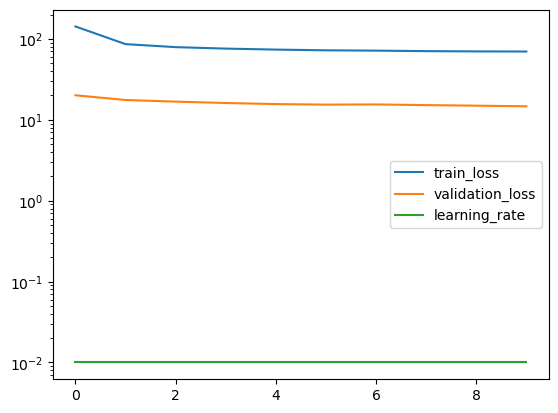

In [2]:
# put all together in a learner
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 20,
                            'n': 100000}}
d_model = 32
model_param = {'device': 'cuda',
               'd_model': d_model, 
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, d_model, None, True),
                               'X2': (50304, d_model, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 1,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=32, epochs=10, gpu=True, 
              save_model='gpt_test_model', target='X1')

In [8]:
# inference
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 10,
                            'prompt': 'All the worlds a stage and all the men and women merely'}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 

                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=None,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=1, epochs=3, gpu=True, squeeze_y_pred=True, 
              load_model='gpt_test_model.pth', target='X1')


len(self.ds_idx):  1
data.nbytes:  24
CDataset created...
CModel loaded...
model loaded from state_dict...
running model on gpu...

...........................
learning time: 0:00:00.175416
last predictions: 
RY suchD gro YORKgWhat Tower Here cast

inference 2024-12-31 09:49:36.903671 complete and saved to csv...


In [9]:
learn.metrics.predictions

[' near lawsTo drift ButOS do Towerman face',
 ' nearCORPET yourself notaciousWhat laws indeed cast',
 'RY suchD gro YORKgWhat Tower Here cast']